# REINFORCE

This notebook implements and demonstrates the REINFORCE algorithm for the Frozen Lake environment. We will also compare it with REINFORCE with baseline.

REINFORCE is an on-policy algorithm for learning a policy $\pi_\theta$ to maximize the expected return $J(\theta)$:

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \gamma^t r(s_t, a_t) \right]$$

where $\tau = (s_0, a_0, s_1, a_1, \ldots)$ is a trajectory, $r(s_t, a_t)$ is the reward at time $t$, and $\gamma$ is the discount factor.


Episode: 0, Total Reward: -405.780993593148
Episode: 100, Total Reward: -84.0674839711435
Episode: 200, Total Reward: -49.00313997941281
Episode: 300, Total Reward: -68.75045488030042
Episode: 400, Total Reward: -8.025294055084686
Episode: 500, Total Reward: -37.27255389147652
Episode: 600, Total Reward: -3.263835992887465
Episode: 700, Total Reward: 18.068497206287574
Episode: 800, Total Reward: -67.60187977057446
Episode: 900, Total Reward: 24.278999721676836
Episode: 1000, Total Reward: -40.348362304203405
Episode: 1100, Total Reward: 10.518008184636301
Episode: 1200, Total Reward: 45.33034921796337
Episode: 1300, Total Reward: 30.423099606289526
Episode: 1400, Total Reward: -14.582351287112331
Episode: 1500, Total Reward: 44.24484720581803
Episode: 1600, Total Reward: 30.795157509925417
Episode: 1700, Total Reward: 100.6032206133205
Episode: 1800, Total Reward: -194.41287773118725
Episode: 1900, Total Reward: 100.7771738971621
Episode: 2000, Total Reward: 90.41514082401395
Episode:

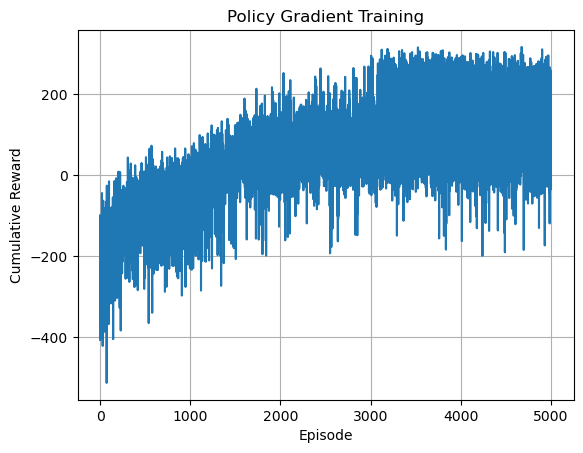

In [5]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        self.fc = nn.Linear(state_size, action_size)

    def forward(self, x):
        x = self.fc(x)
        return torch.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs.squeeze(0)[action])

        return action, log_prob

def reinforce(env, policy, optimizer, n_episodes=5000, gamma=0.99):
    all_rewards = []
    for episode in range(n_episodes):
        log_probs = []
        rewards = []
        state = env.reset()

        state = state[0]

        while True:
            action, log_prob = policy.act(state)
            log_probs.append(log_prob)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)

            if terminated or truncated:
                break

        # Compute cumulative rewards
        all_rewards.append(sum(rewards))

        returns = []
        R = 0
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)

        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {sum(rewards)}")

    # Visualize rewards over time
    import matplotlib.pyplot as plt
    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Policy Gradient Training')
    plt.grid()
    plt.show()

env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy = Policy(state_size, action_size)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
reinforce(env, policy, optimizer)


In [7]:
env = gym.make("LunarLander-v3", render_mode="human")

# Evaluate the policy
state = env.reset()
state = state[0]
rewards = []
while True:
    # env.render()
    action, _ = policy.act(state)
    state, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        break

env.close()
print("Total reward:", sum(rewards))

Total reward: 265.3359167098007


Episode 0, Policy Loss: -30.89786148071289, Baseline Loss: 787.3668212890625
Episode 100, Policy Loss: -18.180950164794922, Baseline Loss: 503.1419372558594
Episode 200, Policy Loss: -4.470546722412109, Baseline Loss: 333.09307861328125
Episode 300, Policy Loss: -1.1218454837799072, Baseline Loss: 193.12667846679688
Episode 400, Policy Loss: -9.359908103942871, Baseline Loss: 428.25067138671875
Episode 500, Policy Loss: -1.3751245737075806, Baseline Loss: 490.4818420410156
Episode 600, Policy Loss: -2.182192087173462, Baseline Loss: 308.46026611328125
Episode 700, Policy Loss: -4.8841681480407715, Baseline Loss: 351.7484130859375
Episode 800, Policy Loss: -4.097753524780273, Baseline Loss: 739.36279296875
Episode 900, Policy Loss: -3.285861015319824, Baseline Loss: 271.78118896484375
Episode 1000, Policy Loss: 5.424381732940674, Baseline Loss: 142.7687225341797
Episode 1100, Policy Loss: 6.349100112915039, Baseline Loss: 115.5198745727539
Episode 1200, Policy Loss: -1.7275588512420654,

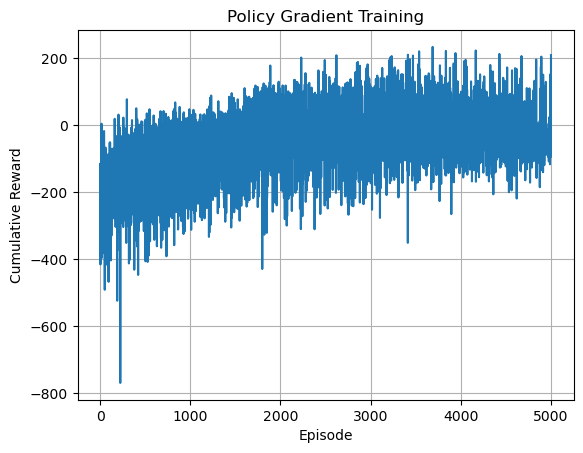

In [15]:
class Baseline(nn.Module):
    def __init__(self, input_size, output_size):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        return out

def reinforce_with_baseline(env, policy, baseline, policy_optimizer, baseline_optimizer, num_episodes, gamma=0.99):
    all_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        baselines = []

        state = state[0]

        while True:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)

            log_prob = torch.log(action_probs.squeeze(0)[action])
            log_probs.append(log_prob)
            rewards.append(reward)

            baseline_value = baseline(state_tensor)
            baselines.append(baseline_value)

            state = next_state

            if terminated or truncated:
                break

        all_rewards.append(sum(rewards))
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float)
        baselines = torch.cat(baselines).squeeze()

        with torch.no_grad():
            advantages = returns - baselines

        policy_loss = []
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss.append(-log_prob * advantage)

        policy_optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).mean()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        baseline_loss = nn.MSELoss()(baselines, returns)
        baseline_optimizer.zero_grad()
        baseline_loss.backward()
        baseline_optimizer.step()

        if episode % 100 == 0:
            print(f"Episode {episode}, Policy Loss: {policy_loss.item()}, Baseline Loss: {baseline_loss.item()}")

    # Visualize rewards over time
    import matplotlib.pyplot as plt
    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Policy Gradient Training')
    plt.grid()
    plt.show()

env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy = Policy(state_size, action_size)
baseline = Baseline(state_size, 1)
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)
baseline_optimizer = optim.Adam(baseline.parameters(), lr=1e-2)

num_episodes = 5000
reinforce_with_baseline(env, policy, baseline, policy_optimizer, baseline_optimizer, num_episodes, 0.9)

In [14]:
env = gym.make("LunarLander-v3", render_mode="human")

# Evaluate the policy
state = env.reset()
state = state[0]
rewards = []
while True:
    # env.render()
    action, _ = policy.act(state)
    state, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        break

env.close()
print("Total reward:", sum(rewards))

Total reward: 30.865617687086786
